In [1]:
import numpy as np
import pandas as pd
import polars as pl
import os
import msgpack_numpy as mpn
import msgpack as mp
import matplotlib.pyplot as plt
import cv2
from cv2 import aruco
from scipy.spatial.transform import Rotation as R
from pd_support import *

In [2]:
calib_recording_folder = 'calib_yuvt3'
recording_folder = 'yuv_t3'

# Get calibration frame and transformation

In [3]:
calib_parent_dir = os.path.dirname(os.getcwd())
calib_data_dir = os.path.join(calib_parent_dir, 'MocapData', calib_recording_folder)

calib_video_file = open(os.path.join(calib_data_dir,'webcam_color.msgpack'), 'rb')
calib_timestamp_file = open(os.path.join(calib_data_dir,'webcam_timestamp.msgpack'), 'rb')

calib_video_data = mp.Unpacker(calib_video_file,object_hook=mpn.decode)
calib_timestamp_data = mp.Unpacker(calib_timestamp_file, object_hook=mpn.decode)

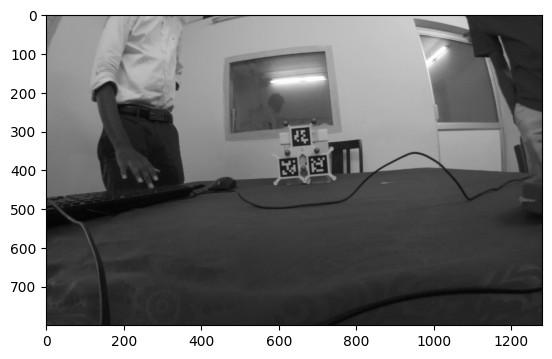

In [4]:
calib_frame = None
for _frame in calib_video_data:
    calib_frame = cv2.flip(_frame, 1)  # Flip frame horizontally
    break

if calib_frame is None:
    raise ValueError("No frames found in calib_video_data.")

dict = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36h11)
parameters = aruco.DetectorParameters()
detector = aruco.ArucoDetector(dict, parameters)
corners, ids, rejectedImgPoints = detector.detectMarkers(calib_frame)
plt.imshow(calib_frame, cmap='gray')

### Calibration mocap path

In [5]:
mocap_file = os.path.join(calib_data_dir, calib_recording_folder+'.csv')
mocap_data, start_time = read_df_csv(mocap_file)

tr_m = get_marker_name('tr')
tl_m = get_marker_name('tl')
bl_m = get_marker_name('bl')
br_m = get_marker_name('br')

yvec = mocap_data[[tr_m['x'], tr_m['y'], tr_m['z']]].values[0] - mocap_data[[br_m['x'], br_m['y'], br_m['z']]].values[0]
xvec = mocap_data[[br_m['x'], br_m['y'], br_m['z']]].values[0] - mocap_data[[bl_m['x'], bl_m['y'], bl_m['z']]].values[0]

del mocap_data
# gram-schmidt process to make yvec orthogonal to xvec
xq = xvec / np.linalg.norm(xvec)
yvec = yvec - np.dot(yvec, xq) * xq
yq = yvec / np.linalg.norm(yvec)
zvec = np.cross(xq, yq)
zq = zvec / np.linalg.norm(zvec)

# rotation matrix from marker to world
R_m2w = np.vstack([xq, yq, zq]).T
# rotation matrix from world to marker
R_w2m = R_m2w.T

# Data path

In [6]:
parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, 'MocapData', recording_folder)

video_file = open(os.path.join(data_dir,'webcam_color.msgpack'), 'rb')
timestamp_file = open(os.path.join(data_dir,'webcam_timestamp.msgpack'), 'rb')

video_data = mp.Unpacker(video_file, object_hook=mpn.decode)
timestamp_data = mp.Unpacker(timestamp_file, object_hook=mpn.decode)

# determine start stop sync pluses
start_sync = None
stop_sync = None
for i, ts in enumerate(timestamp_data):
    _sync = ts[0]
    if _sync == 1 and start_sync is None:
        start_sync = i
    if _sync == 0 and start_sync is not None:
        stop_sync = i
print(f"Start sync: {start_sync}, Stop sync: {stop_sync}")

Start sync: 250, Stop sync: None


# MoCap data path

In [7]:
mocap_file = os.path.join(data_dir, recording_folder+'.csv')
mocap_data, start_time = read_df_csv(mocap_file)

In [8]:
mocap_data.head(3)

,frame,seconds,blv1_x,blv1_y,blv1_z,blv2_x,blv2_y,blv2_z,blv3_x,blv3_y,...,sr_z,tv1_x,tv1_y,tv1_z,tv2_x,tv2_y,tv2_z,tv3_x,tv3_y,tv3_z
0,0,0.00,0.392452,0.137486,-0.038378,0.407930,0.164520,-0.073562,0.365061,0.172392,...,-0.291452,-0.090457,0.063415,0.081144,-0.071107,0.069635,0.038620,-0.117402,0.076163,0.044197
1,1,0.01,0.392387,0.137452,-0.038425,0.407869,0.164518,-0.073560,0.364984,0.172327,...,-0.291179,-0.090455,0.063443,0.081189,-0.071143,0.069680,0.038696,-0.117437,0.076144,0.044265
2,2,0.02,0.392307,0.137446,-0.038454,0.407796,0.164543,-0.073530,0.364887,0.172272,...,-0.291115,-0.090544,0.063556,0.081278,-0.071172,0.069719,0.038749,-0.117508,0.076191,0.044381


In [9]:
mocap_data.columns

Index(['frame', 'seconds', 'blv1_x', 'blv1_y', 'blv1_z', 'blv2_x', 'blv2_y',
       'blv2_z', 'blv3_x', 'blv3_y', 'blv3_z', 'brv1_x', 'brv1_y', 'brv1_z',
       'brv2_x', 'brv2_y', 'brv2_z', 'brv3_x', 'brv3_y', 'brv3_z', 'flv1_x',
       'flv1_y', 'flv1_z', 'flv2_x', 'flv2_y', 'flv2_z', 'flv3_x', 'flv3_y',
       'flv3_z', 'frv1_x', 'frv1_y', 'frv1_z', 'frv2_x', 'frv2_y', 'frv2_z',
       'frv3_x', 'frv3_y', 'frv3_z', 'sl_x', 'sl_y', 'sl_z', 'sr_x', 'sr_y',
       'sr_z', 'tv1_x', 'tv1_y', 'tv1_z', 'tv2_x', 'tv2_y', 'tv2_z', 'tv3_x',
       'tv3_y', 'tv3_z'],
      dtype='object')

In [10]:
# marker sets
shoulder_left = ['sr']
wrist_left = ['flv1', 'flv2', 'flv3']
biceps_left = ['blv1', 'blv2', 'blv3']

shoulder_right = ['sl']
wrist_right = ['frv1', 'frv2', 'frv3']
biceps_right = ['brv1', 'brv2', 'brv3']

trunk = ['tv1', 'tv2', 'tv3']

In [11]:
def return_marker_points(mocap_data, markers):
    points = []
    _marker_name = []
    for _m in markers:
        _marker_name.append(get_marker_name(_m))
    for m in _marker_name:
        points.append(mocap_data[[m['x'], m['y'], m['z']]].values)
    return np.array(points).squeeze()

In [12]:
shoulder_left_points = return_marker_points(mocap_data, shoulder_left)
shoulder_right_points = return_marker_points(mocap_data, shoulder_right)
biceps_left_points = return_marker_points(mocap_data, biceps_left)
biceps_right_points = return_marker_points(mocap_data, biceps_right)
wrist_left_points = return_marker_points(mocap_data, wrist_left)
wrist_right_points = return_marker_points(mocap_data, wrist_right)
trunk_points = return_marker_points(mocap_data, trunk)

In [13]:
biceps_left_points[0]

array([[ 0.392452,  0.137486, -0.038378],
       [ 0.392387,  0.137452, -0.038425],
       [ 0.392307,  0.137446, -0.038454],
       ...,
       [ 0.394561,  0.143844, -0.056372],
       [ 0.394548,  0.143828, -0.056362],
       [ 0.394548,  0.143794, -0.056358]], shape=(2370, 3))

In [14]:
for _t in trunk:
    _markers = [get_marker_name(_t)]
    for _m in _markers:
        print(_m)

{'x': 'tv1_x', 'y': 'tv1_y', 'z': 'tv1_z'}
{'x': 'tv2_x', 'y': 'tv2_y', 'z': 'tv2_z'}
{'x': 'tv3_x', 'y': 'tv3_y', 'z': 'tv3_z'}


# MoCap data path

In [15]:
for _frame in video_data:
    frame = cv2.flip(_frame, 1)  # Flip frame horizontally
    
    break

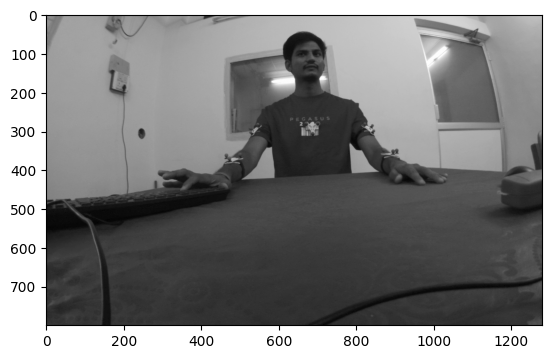

In [16]:
plt.imshow(frame, cmap='gray')

In [ ]:
def project_mocap_to_image(mocap_points_3d, rvec, tvec, camera_matrix, dist_coeffs, 
                           flip_horizontal=False, image_width=1200, 
                           offset_x=0, offset_y=0,
                           offset_3d_x=0, offset_3d_y=0, offset_3d_z=0,
                           flip_mocap_x=False, flip_mocap_y=False, flip_mocap_z=False):
    """
    Project 3D MoCap points to 2D image coordinates using fisheye model
    
    Parameters:
    -----------
    mocap_points_3d : ndarray, shape (N, 3)
        3D points in world coordinates
    rvec : ndarray
        Rotation vector (camera extrinsics)
    tvec : ndarray
        Translation vector (camera extrinsics)
    camera_matrix : ndarray
        Camera intrinsic matrix
    dist_coeffs : ndarray
        Fisheye distortion coefficients
    flip_horizontal : bool
        If True, flip X coordinates to match horizontally flipped image
    image_width : int
        Image width for horizontal flipping (default 1200)
    offset_x : float
        Horizontal offset in pixels to apply after projection
    offset_y : float
        Vertical offset in pixels to apply after projection
    offset_3d_x : float
        3D offset in X direction (meters) in world coordinates before projection
    offset_3d_y : float
        3D offset in Y direction (meters) in world coordinates before projection
    offset_3d_z : float
        3D offset in Z direction (meters) in world coordinates before projection
    flip_mocap_x : bool
        If True, flip the X coordinate of mocap points (mirrors left/right)
    flip_mocap_y : bool
        If True, flip the Y coordinate of mocap points (mirrors up/down)
    flip_mocap_z : bool
        If True, flip the Z coordinate of mocap points (mirrors front/back)
    
    Returns:
    --------
    points_2d : ndarray, shape (N, 2)
        Projected 2D points in image coordinates
    valid_mask : ndarray, shape (N,)
        Boolean mask indicating which points are valid (not NaN)
    """
    # Reshape points if needed
    if len(mocap_points_3d.shape) == 1:
        mocap_points_3d = mocap_points_3d.reshape(1, 3)
    
    # Check for NaN values
    valid_mask = ~np.isnan(mocap_points_3d).any(axis=1)
    
    # If all points are NaN, return empty arrays
    if not valid_mask.any():
        return np.array([]).reshape(0, 2), valid_mask
    
    # Filter out NaN points
    mocap_points_3d_valid = mocap_points_3d[valid_mask].copy()
    
    # Flip mocap coordinates if requested
    if flip_mocap_x:
        mocap_points_3d_valid[:, 0] = -mocap_points_3d_valid[:, 0]
    if flip_mocap_y:
        mocap_points_3d_valid[:, 1] = -mocap_points_3d_valid[:, 1]
    if flip_mocap_z:
        mocap_points_3d_valid[:, 2] = -mocap_points_3d_valid[:, 2]
    
    # Apply 3D offset in world coordinates
    mocap_points_3d_offset = mocap_points_3d_valid.copy()
    mocap_points_3d_offset[:, 0] += offset_3d_x
    mocap_points_3d_offset[:, 1] += offset_3d_y
    mocap_points_3d_offset[:, 2] += offset_3d_z
    
    # Project points using fisheye model
    points_2d, _ = cv2.fisheye.projectPoints(
        mocap_points_3d_offset.reshape(-1, 1, 3),
        rvec,
        tvec,
        camera_matrix,
        dist_coeffs
    )
    
    points_2d = points_2d.reshape(-1, 2)
    
    # Flip X coordinates if image is horizontally flipped
    if flip_horizontal:
        points_2d[:, 0] = image_width - points_2d[:, 0]
    
    # Apply 2D translational offset
    points_2d[:, 0] += offset_x
    points_2d[:, 1] += offset_y
    
    return points_2d, valid_mask

def draw_markers_on_frame(frame, marker_sets, frame_idx, rvec, tvec, camera_matrix, dist_coeffs, R_m2w, 
                          offset_x=0, offset_y=0,
                          offset_3d_x=0, offset_3d_y=0, offset_3d_z=0,
                          flip_mocap_x=False, flip_mocap_y=False, flip_mocap_z=False):
    """
    Draw all MoCap markers on a video frame
    
    Parameters:
    -----------
    frame : ndarray
        Video frame to draw on
    marker_sets : dict
        Dictionary of marker sets with their 3D coordinates
    frame_idx : int
        Frame index to extract from marker data
    R_m2w : ndarray
        Rotation matrix from marker to world coordinates
    offset_x : float
        Horizontal offset in pixels (2D projection space)
    offset_y : float
        Vertical offset in pixels (2D projection space)
    offset_3d_x : float
        3D offset in X direction (meters) in world coordinates
    offset_3d_y : float
        3D offset in Y direction (meters) in world coordinates
    offset_3d_z : float
        3D offset in Z direction (meters) in world coordinates
    flip_mocap_x : bool
        If True, flip the X coordinate of mocap points (mirrors left/right)
    flip_mocap_y : bool
        If True, flip the Y coordinate of mocap points (mirrors up/down)
    flip_mocap_z : bool
        If True, flip the Z coordinate of mocap points (mirrors front/back)
    """
    frame_draw = frame.copy()
    
    # Color scheme for different marker sets
    colors = {
        'shoulder_left': (255, 0, 0),      # Red
        'shoulder_right': (0, 255, 0),     # Green
        'biceps_left': (0, 0, 255),        # Blue
        'biceps_right': (255, 255, 0),     # Cyan
        'wrist_left': (255, 0, 255),       # Magenta
        'wrist_right': (0, 255, 255),      # Yellow
        'trunk': (255, 255, 255)           # White
    }
    
    for name, markers_3d in marker_sets.items():
        # Get 3D points for this frame (in marker coordinate system)
        if len(markers_3d.shape) == 3:
            # Multiple markers (e.g., 3 markers for biceps)
            points_3d_marker = markers_3d[:, frame_idx, :]
        else:
            # Single marker (e.g., shoulder)
            points_3d_marker = markers_3d[frame_idx, :].reshape(1, 3)
        
        # Transform from marker coordinates to world coordinates
        points_3d_world = (R_m2w @ points_3d_marker.T).T
        
        # Project to 2D with NaN handling and optional flip
        points_2d, valid_mask = project_mocap_to_image(
            points_3d_world, rvec, tvec, camera_matrix, dist_coeffs, 
            flip_horizontal=False, image_width=frame.shape[1],
            offset_x=offset_x, offset_y=offset_y,
            offset_3d_x=offset_3d_x, offset_3d_y=offset_3d_y, offset_3d_z=offset_3d_z,
            flip_mocap_x=flip_mocap_x, flip_mocap_y=flip_mocap_y, flip_mocap_z=flip_mocap_z
        )
        
        # Skip if no valid points
        if len(points_2d) == 0:
            continue
        
        # Draw markers
        color = colors.get(name, (128, 128, 128))
        for pt in points_2d:
            # Additional NaN check (safety)
            if not np.isnan(pt).any():
                x, y = int(pt[0]), int(pt[1])
                # Draw circle for each marker
                cv2.circle(frame_draw, (x, y), 5, color, -1)
                # Draw outline
                cv2.circle(frame_draw, (x, y), 6, (0, 0, 0), 2)
        
        # Connect markers in the same set with lines
        if len(points_2d) > 1:
            for i in range(len(points_2d) - 1):
                # Check both points are valid
                if not np.isnan(points_2d[i]).any() and not np.isnan(points_2d[i+1]).any():
                    pt1 = tuple(points_2d[i].astype(int))
                    pt2 = tuple(points_2d[i+1].astype(int))
                    cv2.line(frame_draw, pt1, pt2, color, 2)
    
    return frame_draw

print("Projection functions defined successfully")

In [18]:
# Load fisheye camera calibration
import toml

calib_file = os.path.join(os.path.dirname(os.getcwd()), 'notebooks', 'optimized_fisheye_calibration.toml')
calib_config = toml.load(calib_file)

# Extract camera matrix and distortion coefficients
camera_matrix = np.array(calib_config['calibration']['camera_matrix'])
dist_coeffs = np.array(calib_config['calibration']['dist_coeffs']).flatten()

print("Camera Matrix:")
print(camera_matrix)
print("\nDistortion Coefficients:")
print(dist_coeffs)

Camera Matrix:
[[582.34244292   0.         655.10277004]
 [  0.         586.79367006 336.67876527]
 [  0.           0.           1.        ]]

Distortion Coefficients:
[-0.03400494  0.0060381  -0.01344663  0.00490075]


In [19]:
# Compute camera extrinsics using ArUco markers with MoCap ground truth positions
# The ArUco markers are placed at the corners of the calibration board
# MoCap markers (tr, tl, bl, br) define the same corners in world coordinates

# Get the 3D positions of the ArUco corners from MoCap data (calibration frame)
calib_mocap_file = os.path.join(calib_data_dir, calib_recording_folder+'.csv')
calib_mocap_data, _ = read_df_csv(calib_mocap_file)

# Extract corner markers from MoCap (in marker coordinate system)
tr_m = get_marker_name('tr')
tl_m = get_marker_name('tl')
bl_m = get_marker_name('bl')
br_m = get_marker_name('br')

# Get positions at calibration frame (frame 0)
tr_pos = calib_mocap_data[[tr_m['x'], tr_m['y'], tr_m['z']]].values[0]
tl_pos = calib_mocap_data[[tl_m['x'], tl_m['y'], tl_m['z']]].values[0]
bl_pos = calib_mocap_data[[bl_m['x'], bl_m['y'], bl_m['z']]].values[0]
br_pos = calib_mocap_data[[br_m['x'], br_m['y'], br_m['z']]].values[0]

# Transform corner positions from marker frame to world frame
corners_marker = np.array([tr_pos, tl_pos, bl_pos, br_pos])
corners_world = (R_m2w @ corners_marker.T).T

print("ArUco corner positions in world coordinates:")
print(f"TR (top-right): {corners_world[0]}")
print(f"TL (top-left): {corners_world[1]}")
print(f"BL (bottom-left): {corners_world[2]}")
print(f"BR (bottom-right): {corners_world[3]}")

# Match ArUco detected corners with MoCap positions
# ArUco corners order: [top-left, top-right, bottom-right, bottom-left]
if ids is not None and len(ids) > 0:
    print(f"\nDetected {len(ids)} ArUco marker(s)")
    
    # For each detected marker, establish correspondence
    # Assuming the first detected marker corresponds to the calibration board
    detected_corners_2d = corners[1][0]  # Shape: (4, 2)
    
    # ArUco corner order is: TL, TR, BR, BL
    # Match with MoCap corners: [TL, TR, BR, BL]
    objPoints_mocap = np.array([
        corners_world[1],  # TL
        corners_world[0],  # TR
        corners_world[3],  # BR
        corners_world[2]   # BL
    ], dtype=np.float32)
    
    # Solve PnP using MoCap ground truth positions
    success, rvec, tvec = cv2.solvePnP(
        objPoints_mocap,
        detected_corners_2d,
        camera_matrix,
        dist_coeffs,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    
    if success:
        print(f"\nCamera pose estimated successfully using MoCap ground truth")
        print(f"Rotation vector: {rvec.flatten()}")
        print(f"Translation vector: {tvec.flatten()}")
        
        # Verify by reprojecting the corners
        reprojected, _ = cv2.fisheye.projectPoints(
            objPoints_mocap.reshape(-1, 1, 3),
            rvec,
            tvec,
            camera_matrix,
            dist_coeffs
        )
        reprojected = reprojected.reshape(-1, 2)
        
        print("\nReprojection error:")
        error = np.linalg.norm(detected_corners_2d - reprojected, axis=1)
        print(f"Per corner errors (pixels): {error}")
        print(f"Mean error: {np.mean(error):.2f} pixels")
    else:
        print("Failed to estimate camera pose")
        rvec = np.zeros((3, 1))
        tvec = np.zeros((3, 1))
else:
    print("No ArUco markers detected in calibration frame")
    rvec = np.zeros((3, 1))
    tvec = np.zeros((3, 1))

ArUco corner positions in world coordinates:
TR (top-right): [ 0.03034838  0.14371221 -0.17075354]
TL (top-left): [-0.04198607  0.14673523 -0.20503339]
BL (bottom-left): [-0.04451345  0.06437211 -0.20609336]
BR (bottom-right): [ 0.02968679  0.0653723  -0.17103833]

Detected 3 ArUco marker(s)

Camera pose estimated successfully using MoCap ground truth
Rotation vector: [-3.04800145  0.18516046 -0.61611019]
Translation vector: [0.03977474 0.20073929 0.84955837]

Reprojection error:
Per corner errors (pixels): [0.95887136 1.0472366  0.64176464 0.5569674 ]
Mean error: 0.80 pixels


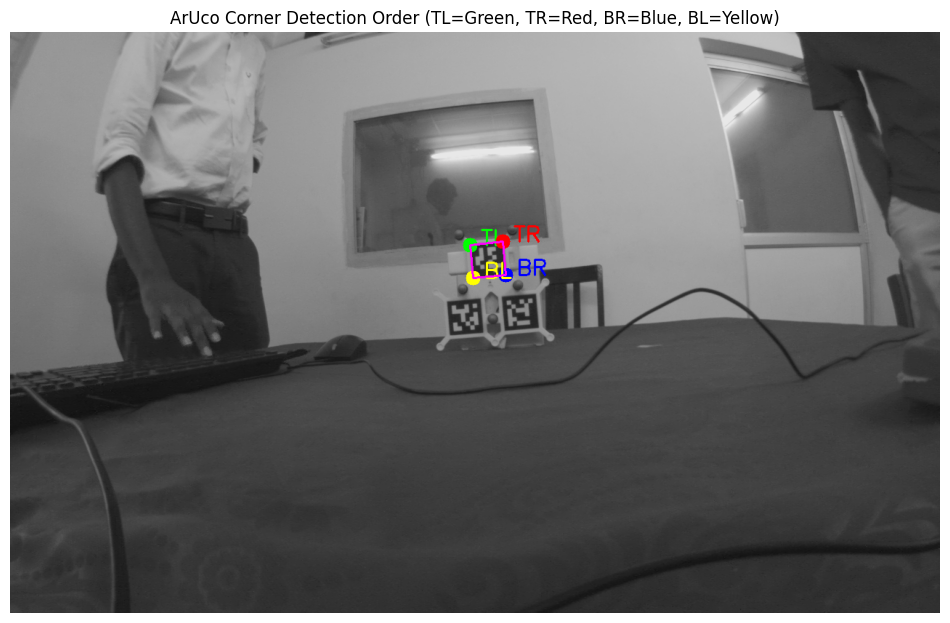

ArUco detected corner order: TL (top-left), TR (top-right), BR (bottom-right), BL (bottom-left)
Please verify this matches the physical marker placement


In [20]:
# Debug: Visualize ArUco corners and their labels to check correspondence
debug_frame = calib_frame.copy()
if len(debug_frame.shape) == 2:
    debug_frame = cv2.cvtColor(debug_frame, cv2.COLOR_GRAY2BGR)

if ids is not None and len(ids) > 0:
    detected_corners_2d = corners[2][0]
    
    # Draw corners with labels (ArUco order: TL, TR, BR, BL)
    corner_labels = ['TL', 'TR', 'BR', 'BL']
    colors_debug = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0)]
    
    for i, (corner, label, color) in enumerate(zip(detected_corners_2d, corner_labels, colors_debug)):
        x, y = int(corner[0]), int(corner[1])
        cv2.circle(debug_frame, (x, y), 10, color, -1)
        cv2.putText(debug_frame, label, (x+15, y), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
    # Draw the ArUco marker outline
    cv2.polylines(debug_frame, [detected_corners_2d.astype(int)], True, (255, 0, 255), 2)

plt.figure(figsize=(12, 8))
plt.imshow(debug_frame)
plt.title('ArUco Corner Detection Order (TL=Green, TR=Red, BR=Blue, BL=Yellow)')
plt.axis('off')
plt.show()

print("ArUco detected corner order: TL (top-left), TR (top-right), BR (bottom-right), BL (bottom-left)")
print("Please verify this matches the physical marker placement")

Applying no_rotation corner mapping correction
Camera pose estimated with no_rotation correction
Reprojection error - Mean: 0.72 pixels, Max: 1.04 pixels


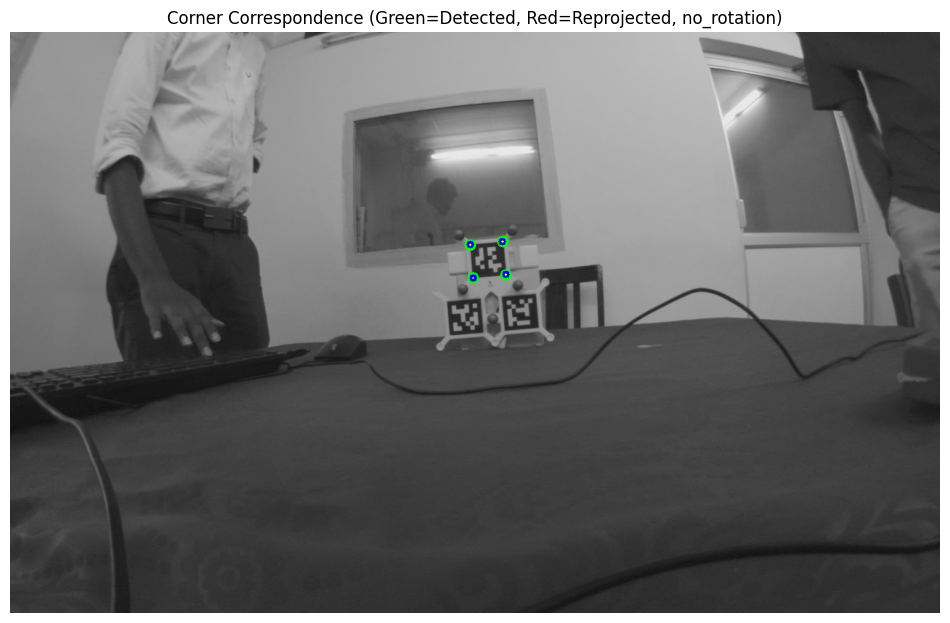


To fix rotation, change 'rotation_correction' to: '90_cw', '90_ccw', '180', or 'no_rotation'


In [21]:
# Fix 90-degree rotation by adjusting corner correspondence
# Try different rotation corrections to match ArUco detection with MoCap marker placement

rotation_mappings = {
    'no_rotation': [corners_world[1], corners_world[0], corners_world[3], corners_world[2]],  # TL, TR, BR, BL
    '90_cw': [corners_world[2], corners_world[1], corners_world[0], corners_world[3]],        # BL, TL, TR, BR
    '90_ccw': [corners_world[0], corners_world[3], corners_world[2], corners_world[1]],       # TR, BR, BL, TL
    '180': [corners_world[3], corners_world[2], corners_world[1], corners_world[0]]           # BR, BL, TL, TR
}

# Change this to fix the rotation: '90_cw', '90_ccw', '180', or 'no_rotation'
rotation_correction = 'no_rotation'

print(f"Applying {rotation_correction} corner mapping correction")

if ids is not None and len(ids) > 0:
    detected_corners_2d = corners[2][0]
    
    # Apply the selected rotation mapping
    objPoints_mocap = np.array(rotation_mappings[rotation_correction], dtype=np.float32)
    
    # Solve PnP with corrected mapping
    success, rvec, tvec = cv2.solvePnP(
        objPoints_mocap,
        detected_corners_2d,
        camera_matrix,
        dist_coeffs,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    
    if success:
        print(f"Camera pose estimated with {rotation_correction} correction")
        
        # Verify by reprojecting the corners
        reprojected, _ = cv2.fisheye.projectPoints(
            objPoints_mocap.reshape(-1, 1, 3),
            rvec,
            tvec,
            camera_matrix,
            dist_coeffs
        )
        reprojected = reprojected.reshape(-1, 2)
        
        error = np.linalg.norm(detected_corners_2d - reprojected, axis=1)
        print(f"Reprojection error - Mean: {np.mean(error):.2f} pixels, Max: {np.max(error):.2f} pixels")
        
        # Visualize the correspondence
        check_frame = calib_frame.copy()
        if len(check_frame.shape) == 2:
            check_frame = cv2.cvtColor(check_frame, cv2.COLOR_GRAY2BGR)
        
        for i, (det, reproj) in enumerate(zip(detected_corners_2d, reprojected)):
            # Draw detected corner (green)
            cv2.circle(check_frame, tuple(det.astype(int)), 8, (0, 255, 0), -1)
            # Draw reprojected corner (red)
            cv2.circle(check_frame, tuple(reproj.astype(int)), 5, (0, 0, 255), -1)
            # Draw line between them
            cv2.line(check_frame, tuple(det.astype(int)), tuple(reproj.astype(int)), (255, 255, 0), 2)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(check_frame)
        plt.title(f'Corner Correspondence (Green=Detected, Red=Reprojected, {rotation_correction})')
        plt.axis('off')
        plt.show()
else:
    print("No ArUco markers detected")

print("\nTo fix rotation, change 'rotation_correction' to: '90_cw', '90_ccw', '180', or 'no_rotation'")

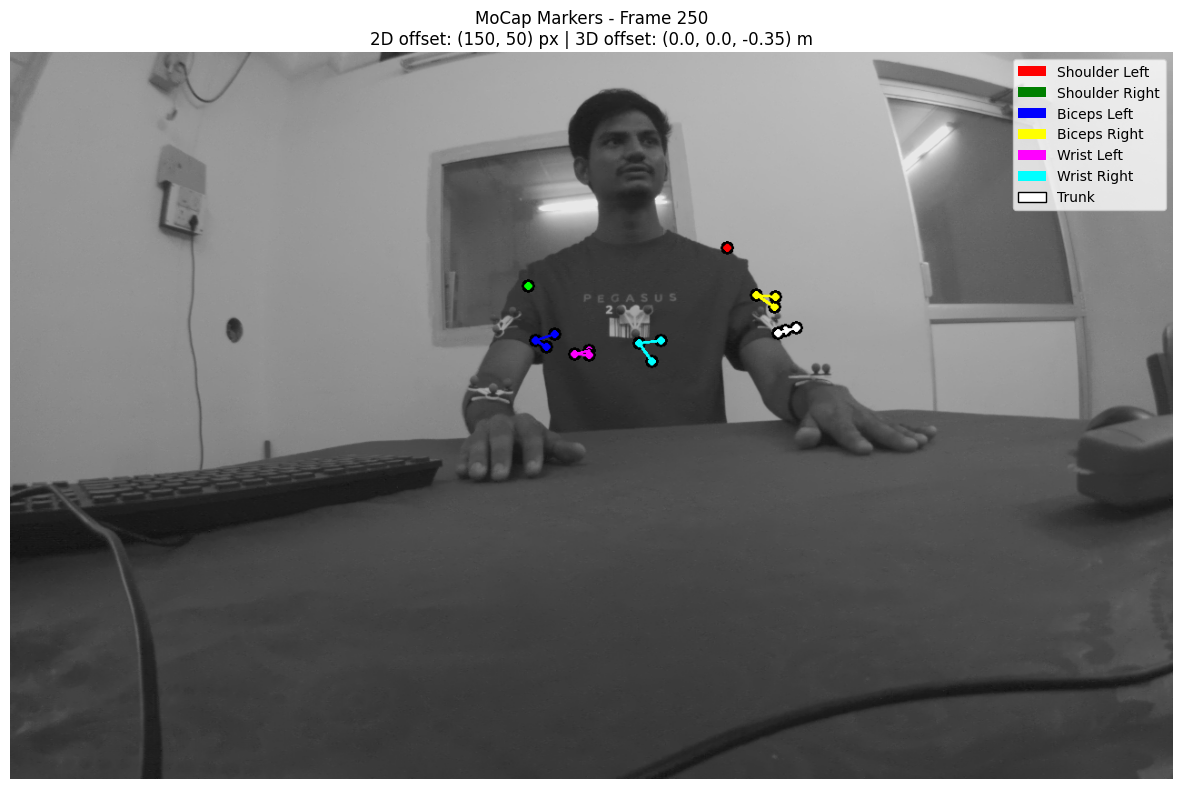


2D Offset (pixels): X=150, Y=50
3D Offset (meters): X=0.0, Y=0.0, Z=-0.35

Tips:
- If markers appear 'forward' (too close to camera), use negative offset_3d_z (e.g., -0.05)
- If markers appear 'backward' (too far from camera), use positive offset_3d_z (e.g., 0.05)
- Adjust 2D offsets (offset_x, offset_y) for simple pixel translations
- Adjust 3D offsets for depth/perspective corrections


In [22]:
# Visualize markers on a single frame with adjustable 2D and 3D offsets
frame_idx = start_sync  # Use the sync start frame

# *** ADJUST THESE VALUES TO FIX ALIGNMENT ***

# 2D offset in image space (applied after projection)
offset_x = 150  # Horizontal offset in pixels (positive = right, negative = left)
offset_y = 50  # Vertical offset in pixels (positive = down, negative = up)

# 3D offset in world coordinates (applied before projection)
# Use these to fix depth/scale issues - if markers appear "forward" of actual position, adjust offset_3d_z
offset_3d_x = 0.0  # X offset in meters (positive = right in world frame)
offset_3d_y = 0.0  # Y offset in meters (positive = up in world frame)
offset_3d_z = -0.35  # Z offset in meters (positive = away from camera, negative = toward camera)

# Prepare marker sets dictionary
marker_sets = {
    'shoulder_left': shoulder_left_points,
    'shoulder_right': shoulder_right_points,
    'biceps_left': biceps_left_points,
    'biceps_right': biceps_right_points,
    'wrist_left': wrist_left_points,
    'wrist_right': wrist_right_points,
    'trunk': trunk_points
}

# Get the frame at sync start
video_file.seek(0)
video_data = mp.Unpacker(video_file, object_hook=mpn.decode)
for i, _frame in enumerate(video_data):
    if i == frame_idx:
        frame = cv2.flip(_frame, 1)
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        break

# Draw markers on frame with R_m2w transformation and offsets
frame_with_markers = draw_markers_on_frame(
    frame, marker_sets, frame_idx, 
    rvec, tvec, camera_matrix, dist_coeffs, R_m2w,
    offset_x=offset_x, offset_y=offset_y,
    offset_3d_x=offset_3d_x, offset_3d_y=offset_3d_y, offset_3d_z=offset_3d_z
)

# Display
plt.figure(figsize=(15, 10))
plt.imshow(frame_with_markers)
plt.title(f'MoCap Markers - Frame {frame_idx}\n2D offset: ({offset_x}, {offset_y}) px | 3D offset: ({offset_3d_x}, {offset_3d_y}, {offset_3d_z}) m')
plt.axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='Shoulder Left'),
    Patch(facecolor='green', label='Shoulder Right'),
    Patch(facecolor='blue', label='Biceps Left'),
    Patch(facecolor='yellow', label='Biceps Right'),
    Patch(facecolor='magenta', label='Wrist Left'),
    Patch(facecolor='cyan', label='Wrist Right'),
    Patch(facecolor='white', edgecolor='black', label='Trunk')
]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

print(f"\n2D Offset (pixels): X={offset_x}, Y={offset_y}")
print(f"3D Offset (meters): X={offset_3d_x}, Y={offset_3d_y}, Z={offset_3d_z}")
print("\nTips:")
print("- If markers appear 'forward' (too close to camera), use negative offset_3d_z (e.g., -0.05)")
print("- If markers appear 'backward' (too far from camera), use positive offset_3d_z (e.g., 0.05)")
print("- Adjust 2D offsets (offset_x, offset_y) for simple pixel translations")
print("- Adjust 3D offsets for depth/perspective corrections")

In [23]:
# Interactive 3D visualization of MoCap markers using Plotly
import plotly.graph_objects as go

def plot_markers_3d_interactive(marker_sets, frame_idx, R_m2w, title="3D MoCap Markers Visualization"):
    """
    Create an interactive 3D plot of MoCap markers using Plotly
    
    Parameters:
    -----------
    marker_sets : dict
        Dictionary of marker sets with their 3D coordinates
    frame_idx : int
        Frame index to visualize
    R_m2w : ndarray
        Rotation matrix from marker to world coordinates
    title : str
        Plot title
    """
    fig = go.Figure()
    
    # Color scheme matching the 2D visualization
    colors_plotly = {
        'shoulder_left': 'red',
        'shoulder_right': 'green',
        'biceps_left': 'blue',
        'biceps_right': 'cyan',
        'wrist_left': 'magenta',
        'wrist_right': 'yellow',
        'trunk': 'white'
    }
    
    for name, markers_3d in marker_sets.items():
        # Get 3D points for this frame (in marker coordinate system)
        if len(markers_3d.shape) == 3:
            # Multiple markers (e.g., 3 markers for biceps)
            points_3d_marker = markers_3d[:, frame_idx, :]
        else:
            # Single marker (e.g., shoulder)
            points_3d_marker = markers_3d[frame_idx, :].reshape(1, 3)
        
        # Transform from marker coordinates to world coordinates
        points_3d_world = (R_m2w @ points_3d_marker.T).T
        
        # Extract X, Y, Z coordinates
        x = points_3d_world[:, 0]
        y = points_3d_world[:, 1]
        z = points_3d_world[:, 2]
        
        color = colors_plotly.get(name, 'gray')
        
        # Add markers as scatter points
        marker_config = {
            'size': 8,
            'color': color,
            'line': {'color': 'black', 'width': 2}
        }
        
        fig.add_trace(go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers+text',
            marker=marker_config,
            text=[name] * len(x),
            name=name,
            hovertemplate=f'<b>{name}</b><br>X: %{{x:.4f}}<br>Y: %{{y:.4f}}<br>Z: %{{z:.4f}}<extra></extra>'
        ))
        
        # Connect markers in the same set with lines
        if len(points_3d_world) > 1:
            line_config = {'color': color, 'width': 4}
            fig.add_trace(go.Scatter3d(
                x=x, y=y, z=z,
                mode='lines',
                line=line_config,
                showlegend=False,
                hoverinfo='skip'
            ))
    
    # Update layout for better visualization
    scene_config = {
        'xaxis_title': 'X (meters)',
        'yaxis_title': 'Y (meters)',
        'zaxis_title': 'Z (meters)',
        'aspectmode': 'data',
        'camera': {'eye': {'x': 1.5, 'y': 1.5, 'z': 1.5}}
    }
    
    legend_config = {
        'x': 0.02,
        'y': 0.98,
        'bgcolor': 'rgba(255, 255, 255, 0.8)'
    }
    
    fig.update_layout(
        title=title,
        scene=scene_config,
        width=1000,
        height=800,
        showlegend=True,
        legend=legend_config
    )
    
    return fig

# Create and display the interactive 3D plot
fig = plot_markers_3d_interactive(marker_sets, frame_idx, R_m2w, 
                                  title=f'3D MoCap Markers - Frame {frame_idx}')
fig.show()

In [ ]:
# Create synchronized video with motion capture markers overlaid on camera frames

def create_synced_video(video_file_path, timestamp_file_path, mocap_data, marker_sets, 
                       rvec, tvec, camera_matrix, dist_coeffs, R_m2w, 
                       output_path, start_sync_frame, stop_sync_frame=None,
                       offset_x=150, offset_y=50, 
                       offset_3d_x=0.0, offset_3d_y=0.0, offset_3d_z=-0.35,
                       flip_mocap_x=False, flip_mocap_y=False, flip_mocap_z=False,
                       fps=30):
    """
    Create a video with motion capture markers synchronized and overlaid on camera frames
    
    Parameters:
    -----------
    video_file_path : str
        Path to webcam_color.msgpack file
    timestamp_file_path : str
        Path to webcam_timestamp.msgpack file
    mocap_data : DataFrame
        MoCap data with 'seconds' column
    marker_sets : dict
        Dictionary of marker sets with 3D coordinates
    rvec, tvec : ndarray
        Camera extrinsics
    camera_matrix, dist_coeffs : ndarray
        Camera intrinsics
    R_m2w : ndarray
        Rotation matrix from marker to world coordinates
    output_path : str
        Output video file path
    start_sync_frame : int
        Frame index where sync pulse starts
    stop_sync_frame : int or None
        Frame index where sync pulse stops (None = end of video)
    offset_x, offset_y : float
        2D pixel offsets
    offset_3d_x, offset_3d_y, offset_3d_z : float
        3D world coordinate offsets (meters)
    flip_mocap_x : bool
        If True, flip the X coordinate (mirrors left/right movement)
    flip_mocap_y : bool
        If True, flip the Y coordinate (mirrors up/down movement)
    flip_mocap_z : bool
        If True, flip the Z coordinate (mirrors front/back movement)
    fps : int
        Output video frame rate
    """
    from datetime import datetime
    
    # Load video timestamps
    with open(timestamp_file_path, 'rb') as f:
        timestamp_data = mp.Unpacker(f, object_hook=mpn.decode)
        video_timestamps = []
        for ts in timestamp_data:
            video_timestamps.append(ts)
    
    # Parse timestamp format: [sync_signal, 'datetime_string']
    # Convert datetime strings to seconds since epoch
    video_datetimes = []
    for ts in video_timestamps:
        if isinstance(ts, (list, tuple)):
            # Format: [sync, 'YYYY-MM-DD HH:MM:SS.ffffff']
            dt_str = str(ts[1])
            dt = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S.%f')
            video_datetimes.append(dt)
        else:
            print(f"Warning: Unexpected timestamp format: {ts}")
    
    # Convert to seconds relative to first timestamp
    first_dt = video_datetimes[0]
    video_times = np.array([(dt - first_dt).total_seconds() for dt in video_datetimes])
    
    # Make relative to sync start frame
    video_times = video_times - video_times[start_sync_frame]
    
    # Get mocap times
    mocap_times = mocap_data['seconds'].values
    
    # Determine video range to process
    end_frame = stop_sync_frame if stop_sync_frame is not None else len(video_timestamps)
    num_frames = end_frame - start_sync_frame
    
    # Build flip status string
    flip_status = []
    if flip_mocap_x:
        flip_status.append('X')
    if flip_mocap_y:
        flip_status.append('Y')
    if flip_mocap_z:
        flip_status.append('Z')
    flip_str = f"Flip: {','.join(flip_status)}" if flip_status else "No flip"
    
    print(f"Processing {num_frames} frames from frame {start_sync_frame} to {end_frame}")
    print(f"Video time range: {video_times[start_sync_frame]:.3f}s to {video_times[end_frame-1]:.3f}s")
    print(f"MoCap time range: {mocap_times[0]:.3f}s to {mocap_times[-1]:.3f}s")
    print(f"MoCap axis flips: {flip_str}")
    
    # Open video file
    video_file = open(video_file_path, 'rb')
    video_data = mp.Unpacker(video_file, object_hook=mpn.decode)
    
    # Get first frame to determine video properties
    frames_iter = iter(video_data)
    for i in range(start_sync_frame + 1):
        sample_frame = next(frames_iter)
    sample_frame = cv2.flip(sample_frame, 1)
    if len(sample_frame.shape) == 2:
        sample_frame = cv2.cvtColor(sample_frame, cv2.COLOR_GRAY2BGR)
    
    height, width = sample_frame.shape[:2]
    
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    if not out.isOpened():
        raise RuntimeError(f"Failed to open video writer for {output_path}")
    
    print(f"Video output: {width}x{height} @ {fps}fps")
    
    # Reopen video file to start from beginning
    video_file.close()
    video_file = open(video_file_path, 'rb')
    video_data = mp.Unpacker(video_file, object_hook=mpn.decode)
    
    # Process frames
    frame_count = 0
    for i, _frame in enumerate(video_data):
        # Skip frames before sync start
        if i < start_sync_frame:
            continue
        if i >= end_frame:
            break
        
        # Get current video time
        current_video_time = video_times[i]
        
        # Find corresponding mocap frame via interpolation
        if current_video_time < mocap_times[0] or current_video_time > mocap_times[-1]:
            # Handle out of range gracefully
            if current_video_time < mocap_times[0]:
                mocap_frame_idx = 0
            else:
                mocap_frame_idx = len(mocap_times) - 1
        else:
            # Find the closest mocap frame
            mocap_frame_idx = np.searchsorted(mocap_times, current_video_time)
            mocap_frame_idx = min(mocap_frame_idx, len(mocap_times) - 1)
        
        # Prepare frame
        frame = cv2.flip(_frame, 1)
        if len(frame.shape) == 2:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        
        # Draw markers on frame
        frame_with_markers = draw_markers_on_frame(
            frame, marker_sets, mocap_frame_idx,
            rvec, tvec, camera_matrix, dist_coeffs, R_m2w,
            offset_x=offset_x, offset_y=offset_y,
            offset_3d_x=offset_3d_x, offset_3d_y=offset_3d_y, offset_3d_z=offset_3d_z,
            flip_mocap_x=flip_mocap_x, flip_mocap_y=flip_mocap_y, flip_mocap_z=flip_mocap_z
        )
        
        # Add timestamp overlay
        timestamp_text = f"Time: {current_video_time:.3f}s | Frame: {i} | MoCap: {mocap_frame_idx}"
        if flip_status:
            timestamp_text += f" | Flip: {','.join(flip_status)}"
        cv2.putText(frame_with_markers, timestamp_text, (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Write frame to video
        out.write(frame_with_markers)
        frame_count += 1
        
        # Progress update
        if frame_count % 30 == 0:
            print(f"Processed {frame_count}/{num_frames} frames ({100*frame_count/num_frames:.1f}%)")
    
    # Cleanup
    video_file.close()
    out.release()
    
    print(f"\nVideo saved to: {output_path}")
    print(f"Total frames written: {frame_count}")
    print(f"Duration: {frame_count/fps:.2f} seconds")
    
    return output_path

print("Video creation function defined successfully")

In [ ]:
# Generate the synchronized video
output_video_path = os.path.join(data_dir, 'synchronized_output.mp4')

video_file_path = os.path.join(data_dir, 'webcam_color.msgpack')
timestamp_file_path = os.path.join(data_dir, 'webcam_timestamp.msgpack')

# *** TOGGLE THESE TO FIX COORDINATE SYSTEM MIRRORING ***
# Set to True for any axis where the markers move opposite to actual movement
flip_mocap_x = True   # Left/Right: True if hand moves left but markers move right
flip_mocap_y = True   # Up/Down: True if hand moves up but markers move down
flip_mocap_z = False  # Front/Back: True if hand moves forward but markers move backward

# Create the video using the optimized offset values from earlier visualization
create_synced_video(
    video_file_path=video_file_path,
    timestamp_file_path=timestamp_file_path,
    mocap_data=mocap_data,
    marker_sets=marker_sets,
    rvec=rvec,
    tvec=tvec,
    camera_matrix=camera_matrix,
    dist_coeffs=dist_coeffs,
    R_m2w=R_m2w,
    output_path=output_video_path,
    start_sync_frame=start_sync,
    stop_sync_frame=stop_sync,
    offset_x=150,        # Use the optimized 2D offsets
    offset_y=50,
    offset_3d_x=0.0,     # Use the optimized 3D offsets
    offset_3d_y=0.0,
    offset_3d_z=-0.35,
    flip_mocap_x=flip_mocap_x,  # Apply flip toggles
    flip_mocap_y=flip_mocap_y,
    flip_mocap_z=flip_mocap_z,
    fps=30
)

print(f"\nVideo generation complete!")
print(f"Output file: {output_video_path}")

# Show which axes were flipped
flip_status = []
if flip_mocap_x:
    flip_status.append('X (left/right)')
if flip_mocap_y:
    flip_status.append('Y (up/down)')
if flip_mocap_z:
    flip_status.append('Z (front/back)')
if flip_status:
    print(f"Flipped axes: {', '.join(flip_status)}")
else:
    print("No axes flipped")

In [26]:
# Debug: Check the timestamp format
import msgpack as mp
import msgpack_numpy as mpn

timestamp_file_path = os.path.join(data_dir, 'webcam_timestamp.msgpack')
with open(timestamp_file_path, 'rb') as f:
    timestamp_data = mp.Unpacker(f, object_hook=mpn.decode)
    sample_timestamps = []
    for i, ts in enumerate(timestamp_data):
        sample_timestamps.append(ts)
        if i >= 5:  # Just check first few
            break

print("Sample timestamps:")
for i, ts in enumerate(sample_timestamps):
    print(f"Index {i}: {ts} (type: {type(ts)})")
    if isinstance(ts, (list, tuple, np.ndarray)):
        print(f"  Length: {len(ts)}")
        for j, val in enumerate(ts):
            print(f"    [{j}]: {val} (type: {type(val)})")

Sample timestamps:
Index 0: [0, '2025-09-23 16:51:53.630474'] (type: <class 'list'>)
  Length: 2
    [0]: 0 (type: <class 'int'>)
    [1]: 2025-09-23 16:51:53.630474 (type: <class 'str'>)
Index 1: [0, '2025-09-23 16:51:53.642666'] (type: <class 'list'>)
  Length: 2
    [0]: 0 (type: <class 'int'>)
    [1]: 2025-09-23 16:51:53.642666 (type: <class 'str'>)
Index 2: [0, '2025-09-23 16:51:53.650154'] (type: <class 'list'>)
  Length: 2
    [0]: 0 (type: <class 'int'>)
    [1]: 2025-09-23 16:51:53.650154 (type: <class 'str'>)
Index 3: [0, '2025-09-23 16:51:53.664108'] (type: <class 'list'>)
  Length: 2
    [0]: 0 (type: <class 'int'>)
    [1]: 2025-09-23 16:51:53.664108 (type: <class 'str'>)
Index 4: [0, '2025-09-23 16:51:53.678602'] (type: <class 'list'>)
  Length: 2
    [0]: 0 (type: <class 'int'>)
    [1]: 2025-09-23 16:51:53.678602 (type: <class 'str'>)
Index 5: [0, '2025-09-23 16:51:53.690034'] (type: <class 'list'>)
  Length: 2
    [0]: 0 (type: <class 'int'>)
    [1]: 2025-09-23 16:51